# Part I: Profiling expression STRs across 17 human tissues

This notebook contains info for:

#### Figures
* **Figure 1D** causal examples

#### Supplementary Tables:
* **Supplementary Table LITERATURE**

In [37]:
%pylab inline
%run params.py

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Import libraries
import os
import pandas as pd
import scipy.stats
import seaborn as sns

############ Set up paths #############
SAVEPLOT = True
PREFIX = "eSTR-calling"
FIGPREFIX = "SuppFig"
DATADIR = os.path.join(BASEDATADIR, PREFIX)
RESULTSDIR = os.path.join(BASERESULTSDIR, PREFIX)

COLORS = {
    "Artery-Aorta":"salmon",
    "Artery-Tibial": "red",
    "Adipose-Subcutaneous": "darkorange",    
    "Adipose-Visceral":"orange",
    "Brain-Caudate":"lemonchiffon"   , 
    "Brain-Cerebellum":"yellow",
    "Cells-Transformedfibroblasts": "skyblue",
    "Esophagus-Mucosa": "sienna",
    "Esophagus-Muscularis":"burlywood",
    "Heart-LeftVentricle":"darkviolet",
    "Lung": "greenyellow",
    "Muscle-Skeletal": "mediumslateblue",
    "Nerve-Tibial":"gold",
    "Skin-NotSunExposed":"blue",
    "Skin-SunExposed":"cornflowerblue",
    "Thyroid":"green",
    "WholeBlood": "m",
}
TISSUES = COLORS.keys()

############ Load linear regression data #############
data = {} # Map of tissue -> data
for t in TISSUES:
    data[t] = pd.read_csv(os.path.join(DATADIR, "%s_LinearRegression.tab"%t), sep="\t", usecols=[0,1,3,8,11])
    data[t]["str.start"] = (data[t]["str.start"]).apply(int)

Populating the interactive namespace from numpy and matplotlib


In [38]:
# Get best tissue for a given eSTR
PTHRESH = 0.01
def GetBestTissue(chrom, start, gene, data):
    """
    Return tissue, pval, beta
    """
    best_tissue = None
    best_p = 1
    best_beta = None
    for t in data:
        x = data[t]
        x = x[(x["chrom"]==chrom) & (x["str.start"]==start) & (x["gene"]==gene)]
        if x.shape[0] == 0: continue
        if x["p.wald"].values[0] <= best_p:
            best_tissue = t
            best_p = x["p.wald"].values[0]
            best_beta = x["beta"].values[0]
        if  x["p.wald"].values[0] < PTHRESH:
            print("%s %s %s"%(t, x["p.wald"].values[0], x["beta"].values[0]))
    return best_tissue, best_p, best_beta

def ExtractData(gene, chrom, start, tissue):
    if "(" in tissue: tissue = tissue.split("(")[0]
    vcf = "/storage/szfeupe/Runs/650GTEx_estr/Merged_STRs_all_samples.vcf.gz"
    # Pull out STR genotypes
    cmd = """bcftools query -r %s:%s-%s -f"[%%SAMPLE\\t%%GB\\n]" %s | \
    grep -v "\." | sed 's/|/\\t/' | awk '{print $1 "\\t" $2+$3}' > str_genotypes.tab"""%(chrom.replace("chr",""), start, start, vcf)
    os.system(cmd)
    # Pull out gene expression
    expr="/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/%s/Corr_Expr.csv"%tissue
    colnum = open(expr,"r").readline().split(",").index('"' + gene + '"')+2
    cmd = """cat %s | cut -d',' -f 1,%s | grep -v ENSG > expr.tab"""%(expr, colnum)
    os.system(cmd)
    
def PlotESTR(gene, tissue, chrom, start, end, COLORS, fname=None):
    ExtractData(gene, chrom, start, tissue)
    strgt = pd.read_csv("str_genotypes.tab", sep="\t", names=["sample","str"])
    strgt["sample"] = strgt["sample"].apply(lambda x: "-".join(x.split("-")[0:2]))
        
    rmgts = []
    for gt in sorted(list(set(strgt["str"]))):
        if strgt[strgt["str"]==gt].shape[0] <3: rmgts.append(gt)
    strgt = strgt[strgt["str"].apply(lambda x: x not in rmgts)]
        
    fig = plt.figure()
    ax = fig.add_subplot(111)
    expr = pd.read_csv("expr.tab", names=["sample","expr"])
    data = pd.merge(strgt, expr)
    sns.swarmplot(x="str", y="expr", ax=ax, data=data, color=COLORS[tissue])
    
    means = data.groupby("str", as_index = False).agg({"expr": np.mean})
    means = means.sort_values("str")
    means["num"] = range(means.shape[0])
    
    ax.plot(means["num"], means["expr"], color="black", marker="o")
    ax.set_xlabel("Allele length (bp)", size=15)
    ax.set_ylabel("Expression - %s"%tissue, size=15)
    ax.set_xticklabels([int(item)+(end-start+2) for item in sorted(list(set(data["str"])))], size=12)
    ax.set_yticklabels(["%.2f"%(item) for item in ax.get_yticks()], size=12)
    ax.set_title("")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    plt.suptitle("");
    plt.show()
    if fname is not None: fig.savefig(fname)

# CSTB

https://www.ncbi.nlm.nih.gov/pubmed/9126745
repeat involved in EPM1 (progressive myoclonus epilepsy MIM 254800)
mutant alleles contain 60+ copies. normal alleles 2-3 copies

https://www.ncbi.nlm.nih.gov/pubmed/22573514
CSTB causal eQTL. Figure 1B. more repeats = more expression

https://www.ncbi.nlm.nih.gov/pubmed/10441345
propose here the mechanism is altered spacing

WholeBlood 2.1014922735574548e-14 0.4070895467591639
Artery-Tibial 2.2954051577385685e-15 0.4581644098671728
Heart-LeftVentricle 1.630030072311266e-11 0.4614220913424358
Adipose-Subcutaneous 0.0001891850722444315 0.2290882993859059
Thyroid 4.1322697025400756e-16 0.4801373588533952
Artery-Aorta 1.9626488165263646e-05 0.30828105920092885
Skin-NotSunExposed 6.339980281606235e-07 0.3419327648502498
Cells-Transformedfibroblasts 1.4904429779250703e-18 0.5521154466758411
Adipose-Visceral 2.4937880117961275e-06 0.33822105996552443
Nerve-Tibial 7.331667966724233e-14 0.4451180552487229
Muscle-Skeletal 1.286148195159528e-21 0.4904589924356517
Esophagus-Muscularis 2.7563910296998874e-09 0.4020328183061333
Skin-SunExposed 1.8756893481002583e-14 0.4296000313279473


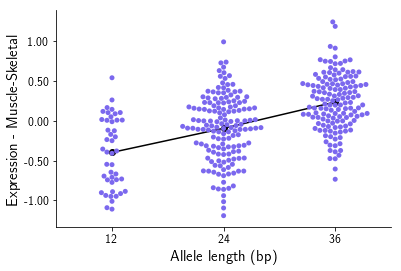

In [53]:
chrom = "chr21"
start = 45196326
end = 45196360
gene = "ENSG00000160213.5"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_CSTB.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# PIG3 (TP53I3)

https://www.nature.com/articles/ng836
number of repeats positively correlated with expression, only in the presence of p53 (Figure 5b)

Esophagus-Mucosa 0.008148316941980148 0.1763826888243387
Thyroid 0.0006043215012692471 0.2216459057733232
Muscle-Skeletal 0.006844134473106718 0.15480586780044353


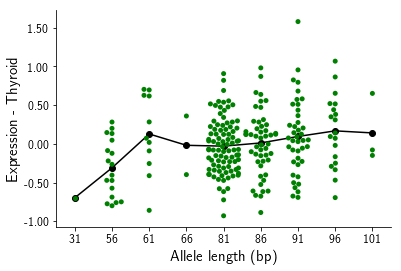

In [40]:
chrom = "chr2"
start = 24307211
end = 24307290
gene = "ENSG00000115129.9"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_PIG3.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS)

# MMP9

https://www.ncbi.nlm.nih.gov/pubmed/10428474
polyCA, esophageal carcinoma cell lines
longer repeat = more expression
Figure 3
range tested 0-21 repeats
most Japanese had 20, 21, or 22 repeats

Skin-SunExposed 0.003908333059473693 0.18187989470752275


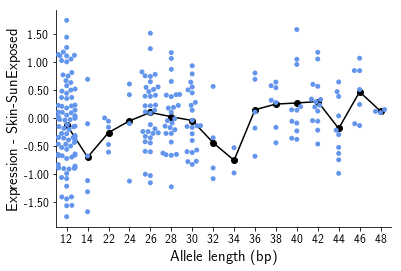

In [41]:
chrom = "chr20"
start = 44637412
end = 44637458
gene = "ENSG00000100985.7"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_MMP9.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS)

# EGFR

http://www.jbc.org/content/274/19/13176.long
Figure 4A
16-21 in vivo nonlinear (16 and 20 highest; various cell lines have different numbers)
16-21 in vitro show decreasing trend with expression

Esophagus-Mucosa 0.0017561588027997658 0.21266338120795727
Heart-LeftVentricle 0.007359973711983423 -0.20856936945691976
Muscle-Skeletal 0.006974538202550474 0.15839261663021156


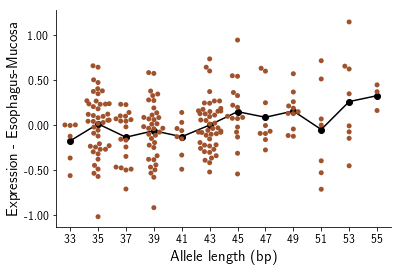

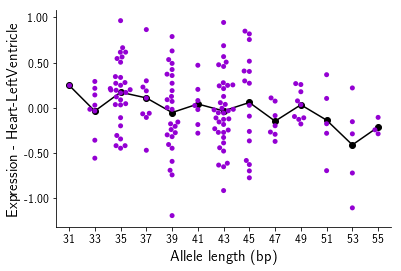

In [42]:
chrom="chr7"
start = 55088253
end = 55088286
gene = "ENSG00000146648.11"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_EGFR.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS)
PlotESTR(gene, "Heart-LeftVentricle", chrom, start, end, COLORS)

# IFNG

https://www.ncbi.nlm.nih.gov/pubmed/15900487

CA12 and CA15 with decreased and increased expression

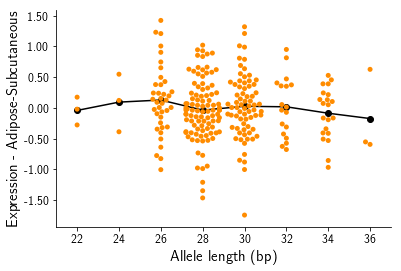

In [43]:
chrom="chr12"
start = 68552495
end = 68552523
gene = "ENSG00000111537.4"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_IFNG.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS)

# UGT1A1
https://www.ncbi.nlm.nih.gov/pubmed/7565971
human hepatoma
longer repeat = reduced expression

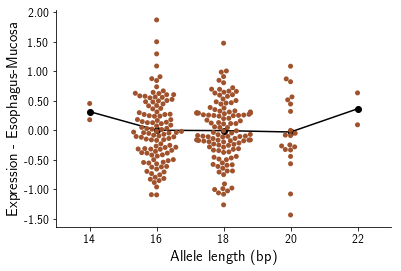

In [44]:
chrom="chr2"
start = 234668880
end = 234668894
gene = "ENSG00000241635.3"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_Gilbert.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS)

# NOP56

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3135815/
expansion causes SCA36

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5504081/
reduced expression in ipscs of patients (bit expansions)

Artery-Tibial 9.530137450101992e-05 0.2369619492780936
Adipose-Subcutaneous 0.0010882684400698 0.2003387759679452
Thyroid 2.4089756567925805e-08 0.3399550374134861
Skin-NotSunExposed 0.003983216894907949 0.20176436491436384
Muscle-Skeletal 7.763973061996127e-12 0.3639638161260791
Skin-SunExposed 5.980036839593017e-05 0.2342239733210593


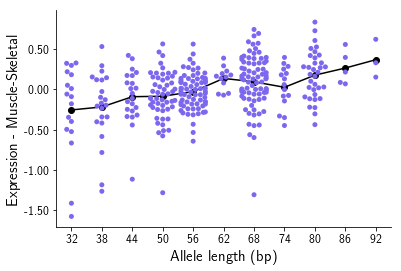

In [54]:
chrom="chr20"
start=2633379
end = 2633421
gene = "ENSG00000101361.10"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_NOP56.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# VLDLR

WholeBlood 8.626591585226099e-14 -0.3958859573307789


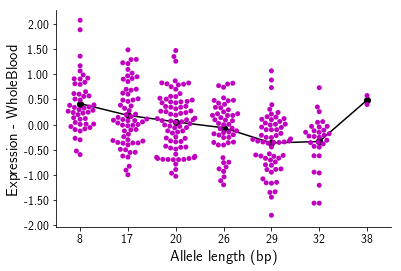

In [46]:
gene = "ENSG00000147852.11"
chrom = "chr9"
start = 2622147
end = 2622171

best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_VLDLR.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS)

# Jacobsen Syndrome

Cells-Transformedfibroblasts 0.0039303911901327464 -0.1968094713500796


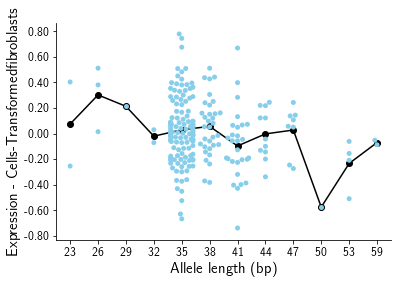

In [47]:
gene = "ENSG00000110395.4"
chrom = "chr11"
start = 119077000
end = 119077033
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_CBL.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS)

# ALOX5


Esophagus-Mucosa 4.347912095386305e-07 0.31737116597155063
Brain-Cerebellum 0.00270767041900817 0.28984312234623305
Skin-SunExposed 0.0009001337755839648 -0.1939411613489228


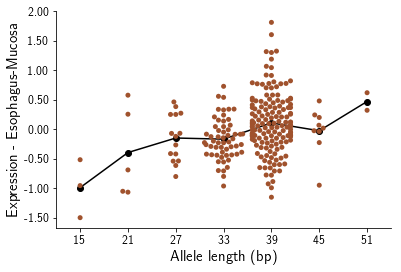

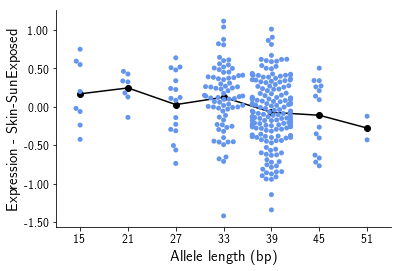

In [56]:
gene = "ENSG00000012779.6"
chrom = "chr10"
start = 45869548
end = 45869585
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_ALOX5.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)
PlotESTR(gene, "Skin-SunExposed", chrom, start, end, COLORS)

# Below are additional examples where expression is not directly tested

# SCNA
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6054541/

repeat length pos relationship with expression
increases binding of nearby TF sites
don't directly test expression

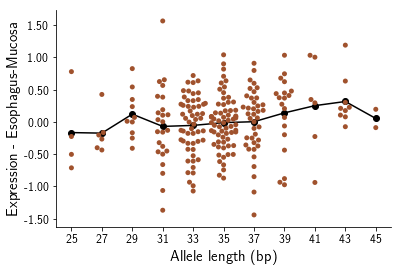

In [48]:
chrom = "chr4"
start = 90636808
end = 90636841
gene = "ENSG00000145335.11"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_SNCA.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS)